In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [7]:
uhi_data = pd.read_csv('uhi_data_avg.csv')

In [8]:
uhi_data.head()

,Longitude,Latitude,UHI Index,B01,B02,B03,B04,B05,B06,B07,B08,B09,B10,B11,NDVI,NDBI,NDWI,BVW
0,-77.302700,39.109905,0.993571,1369.8191,1561.9429,1721.3619,1628.3239,1958.9143,3097.4570,3504.2761,3639.0286,3682.1333,2666.3713,2026.4286,0.381730,-0.284637,-0.357748,2.084295
1,-77.302690,39.109855,0.994674,1373.8208,1557.4811,1717.9340,1624.8585,1954.0660,3094.1133,3498.4530,3640.3396,3677.2925,2667.3584,2026.2075,0.382793,-0.284853,-0.358773,2.074132
2,-77.302677,39.109960,0.993571,1365.6476,1564.1809,1729.8381,1629.8000,1965.7620,3145.4475,3571.8190,3720.9714,3750.5430,2675.7524,2025.6476,0.390817,-0.295012,-0.365291,2.066463
3,-77.302655,39.109808,0.994674,1378.6168,1550.0281,1709.6168,1617.8318,1946.1495,3070.7476,3468.5234,3628.6729,3648.8225,2657.8037,2021.8037,0.383273,-0.284378,-0.359489,2.063965
4,-77.302630,39.110017,0.993571,1360.0447,1551.0625,1727.4464,1612.2142,1963.1161,3231.1875,3694.1428,3876.5000,3880.9731,2692.9106,2015.7411,0.412535,-0.315798,-0.383489,1.996162


Pearson correlation (NDVI): -0.4265


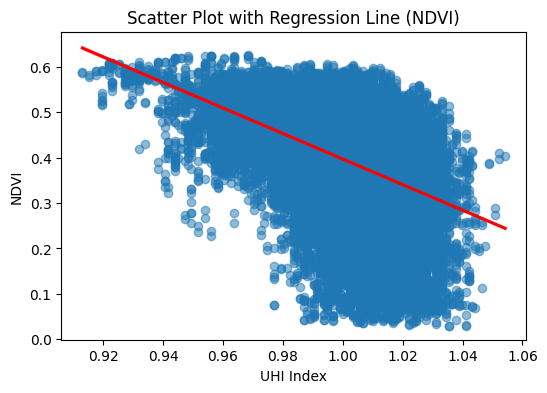

Pearson correlation (NDBI): 0.4324


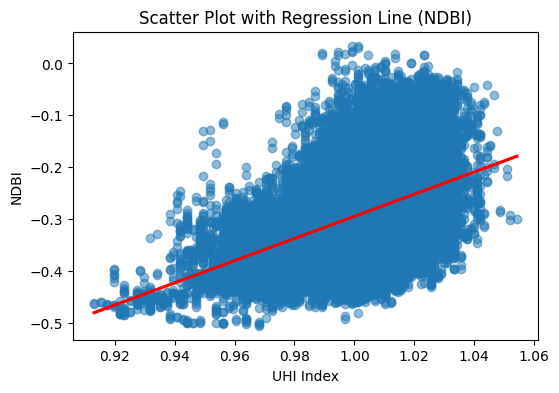

Pearson correlation (NDWI): 0.4285


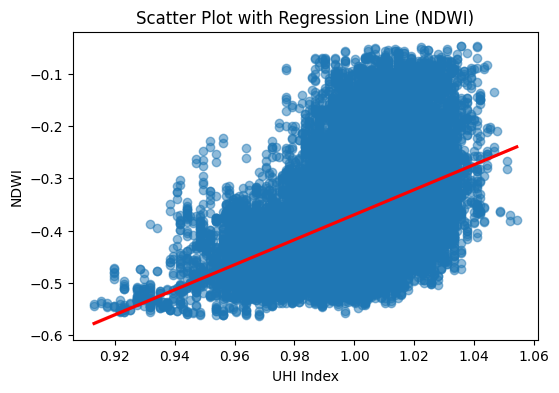

Pearson correlation (BVW): 0.1754


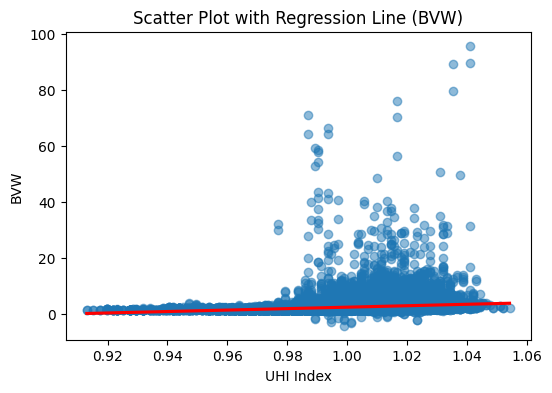

In [9]:
features = ['NDVI', 'NDBI', 'NDWI', 'BVW']
corr = []
for i in range(len(features)):
    correlation = uhi_data['UHI Index'].corr(uhi_data[features[i]])
    corr.append(correlation)  
    print(f'Pearson correlation ({features[i]}): {correlation:.4f}')
    
    
    plt.figure(figsize=(6, 4))
    sns.regplot(x=uhi_data['UHI Index'], y=uhi_data[features[i]], 
                scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title(f"Scatter Plot with Regression Line ({features[i]})")
    plt.show()
    

In [ ]:
uhi_data = uhi_data[['B01', 'NDVI', 'NDBI', 'NDWI', 'UHI Index']]

X = uhi_data.drop(columns=['UHI Index']).values
y = uhi_data['UHI Index'].values


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

uhi_data = uhi_data[['B01', 'NDVI', 'NDBI', 'NDWI', 'UHI Index']]
X = uhi_data.drop(columns=['UHI Index']).values
y = uhi_data['UHI Index'].values

X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y, dtype=torch.float32, device=device).view(-1, 1)

train_size = int(0.8 * len(X))
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

# DataLoader
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


class UHI_MLP(nn.Module):
    def __init__(self, input_dim):
        super(UHI_MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),  # Batch Normalization
            nn.
            out(0.3),  # Dropout (Regularization)
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

input_dim = X.shape[1]
model = UHI_MLP(input_dim).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

model.eval()
with torch.no_grad():
    test_predictions = model(X_test.to(device))
    test_loss = criterion(test_predictions, y_test.to(device)).item()
    
print(f"Test MSE Loss: {test_loss:.4f}")

Using device: mps
Epoch 10/100, Loss: 0.0003
Epoch 20/100, Loss: 0.0003
Epoch 30/100, Loss: 0.0003
Epoch 40/100, Loss: 0.0003
Epoch 50/100, Loss: 0.0003
Epoch 60/100, Loss: 0.0003
Epoch 70/100, Loss: 0.0003
Epoch 80/100, Loss: 0.0003
Epoch 90/100, Loss: 0.0003
Epoch 100/100, Loss: 0.0003
Test MSE Loss: 0.0002


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import r2_score

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

uhi_data = uhi_data[['B01', 'NDVI', 'NDBI', 'NDWI', 'UHI Index']]
X = uhi_data.drop(columns=['UHI Index']).values
y = uhi_data['UHI Index'].values

X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y, dtype=torch.float32, device=device).view(-1, 1)

train_size = int(0.8 * len(X))
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class UHI_MLP(nn.Module):
    def __init__(self, input_dim):
        super(UHI_MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),  # Batch Normalization
            nn.Dropout(0.3),  # Dropout (Regularization)
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

input_dim = X.shape[1]
model = UHI_MLP(input_dim).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    if (epoch+1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            train_predictions = model(X_train.to(device)).cpu().numpy()
            y_train_np = y_train.cpu().numpy()

            train_loss = criterion(torch.tensor(train_predictions), torch.tensor(y_train_np)).item()
            train_r2 = r2_score(y_train_np, train_predictions)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Train MSE: {train_loss:.4f}, Train R²: {train_r2:.4f}")

model.eval()
with torch.no_grad():
    test_predictions = model(X_test.to(device)).cpu().numpy()
    y_test_np = y_test.cpu().numpy()

    test_loss = criterion(torch.tensor(test_predictions), torch.tensor(y_test_np)).item()
    test_r2 = r2_score(y_test_np, test_predictions)

print(f"Final Test MSE Loss: {test_loss:.4f}")
print(f"Final Test R² Score: {test_r2:.4f}")

Using device: mps
Epoch 10/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: 0.0287
Epoch 20/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: 0.0681
Epoch 30/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: 0.2035
Epoch 40/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: 0.1366
Epoch 50/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: -0.0045
Epoch 60/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: -0.0028
Epoch 70/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: -0.0035
Epoch 80/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: -0.0101
Epoch 90/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: -0.0080
Epoch 100/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: -0.0054
Final Test MSE Loss: 0.0002
Final Test R² Score: -0.2003


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

uhi_data = pd.read_csv('uhi_data_all.csv')
X = uhi_data.drop(columns=['UHI Index','Longitude','Latitude']).values
y = uhi_data['UHI Index'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Original feature dimension: {X.shape[1]}")
print(f"Reduced feature dimension (PCA): {X_pca.shape[1]}")

X_tensor = torch.tensor(X_pca, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y, dtype=torch.float32, device=device).view(-1, 1)

train_size = int(0.8 * len(X_pca))
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



class UHI_MLP(nn.Module):
    def __init__(self, input_dim):
        super(UHI_MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),  # Batch Normalization
            nn.Dropout(0.3),  # Dropout (Regularization)
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

input_dim = X_pca.shape[1]
model = UHI_MLP(input_dim).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    if (epoch+1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            train_predictions = model(X_train.to(device)).cpu().numpy()
            y_train_np = y_train.cpu().numpy()

            train_loss = criterion(torch.tensor(train_predictions), torch.tensor(y_train_np)).item()
            train_r2 = r2_score(y_train_np, train_predictions)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Train MSE: {train_loss:.4f}, Train R²: {train_r2:.4f}")

model.eval()
with torch.no_grad():
    test_predictions = model(X_test.to(device)).cpu().numpy()
    y_test_np = y_test.cpu().numpy()

    test_loss = criterion(torch.tensor(test_predictions), torch.tensor(y_test_np)).item()
    test_r2 = r2_score(y_test_np, test_predictions)

print(f"Final Test MSE Loss: {test_loss:.4f}")
print(f"Final Test R² Score: {test_r2:.4f}")

Using device: mps
Original feature dimension: 15
Reduced feature dimension (PCA): 5
Epoch 10/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: 0.1462
Epoch 20/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: 0.2156
Epoch 30/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: 0.1108
Epoch 40/100, Loss: 0.0003, Train MSE: 0.0054, Train R²: -15.3213
Epoch 50/100, Loss: 0.0003, Train MSE: 0.0042, Train R²: -11.6722
Epoch 60/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: 0.2002
Epoch 70/100, Loss: 0.0003, Train MSE: 0.0006, Train R²: -0.9009
Epoch 80/100, Loss: 0.0003, Train MSE: 0.0011, Train R²: -2.4366
Epoch 90/100, Loss: 0.0003, Train MSE: 0.0004, Train R²: -0.1116
Epoch 100/100, Loss: 0.0003, Train MSE: 0.0004, Train R²: -0.1851
Final Test MSE Loss: 0.0001
Final Test R² Score: 0.0475


In [ ]:
feature_names = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12", "NDVI", "NDBI", "NDWI", "BVW"]

pca_components = pd.DataFrame(pca.components_, columns=feature_names)

feature_importance_pca = np.abs(pca.components_).sum(axis=0)
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance_pca})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

print("Most impactful Features:")
print(feature_importance_df.head(5))

PCA에서 가장 영향을 많이 준 Feature들:
   Feature  Importance
12    NDBI    1.279860
0      B01    1.262991
14     BVW    1.174327
7      B08    1.114003
9      B11    1.058341


In [ ]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

feature_importance_rf = rf.feature_importances_

feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance_rf})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

print("랜덤포레스트 Feature Importance:")
print(feature_importance_df.head(5))

랜덤포레스트 Feature Importance:
   Feature  Importance
0      B01    0.301173
4      B05    0.070092
10     B12    0.067109
8      B8A    0.065997
6      B07    0.063660


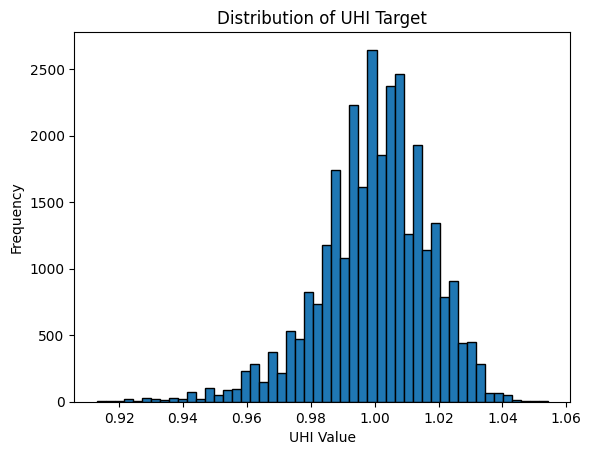

In [29]:
import matplotlib.pyplot as plt

plt.hist(y, bins=50, edgecolor='black')
plt.xlabel("UHI Value")
plt.ylabel("Frequency")
plt.title("Distribution of UHI Target")
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F



device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

uhi_data = pd.read_csv('uhi_data_all.csv')
uhi_data = uhi_data[['UHI Index','B01', 'NDVI', 'NDBI', 'NDWI', 'BVW']]
X = uhi_data.drop(columns=['UHI Index']).values
y = uhi_data['UHI Index'].values

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)

y_train = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device).view(-1, 1)


batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class ResidualMLP(nn.Module):
    def __init__(self, input_dim):
        super(ResidualMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 1)
        
        self.shortcut = nn.Linear(input_dim, 32)


    def forward(self, x):
        residual = self.shortcut(x) 
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = x + residual
        return self.fc4(x)

input_dim = X.shape[1]
model = ResidualMLP(input_dim).to(device)

class HuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super().__init__()
        self.delta = delta

    def forward(self, y_pred, y_true):
        residual = torch.abs(y_true - y_pred)
        loss = torch.where(residual < self.delta, 0.5 * residual**2, self.delta * (residual - 0.5 * self.delta))
        return loss.mean()

criterion = HuberLoss(delta=1.0)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    if (epoch+1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            train_predictions = model(X_train.to(device)).cpu().numpy()
            y_train_np = y_train.cpu().numpy()

            train_loss = criterion(torch.tensor(train_predictions), torch.tensor(y_train_np)).item()
            train_r2 = r2_score(y_train_np, train_predictions)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Train MSE: {train_loss:.4f}, Train R²: {train_r2:.4f}")

model.eval()
with torch.no_grad():
    test_predictions = model(X_test.to(device)).cpu().numpy()
    y_test_np = y_test.cpu().numpy()

    test_loss = criterion(torch.tensor(test_predictions), torch.tensor(y_test_np)).item()
    test_r2 = r2_score(y_test_np, test_predictions)

print(f"Final Test MSE Loss: {test_loss:.4f}")
print(f"Final Test R² Score: {test_r2:.4f}")

Using device: mps
Epoch 10/100, Loss: 0.0008, Train MSE: 0.0008, Train R²: -18.8471
Epoch 20/100, Loss: 0.0004, Train MSE: 0.0005, Train R²: -9.1975
Epoch 30/100, Loss: 0.0004, Train MSE: 0.0003, Train R²: -2.7173
Epoch 40/100, Loss: 0.0004, Train MSE: 0.0006, Train R²: -10.6112
Epoch 50/100, Loss: 0.0004, Train MSE: 0.0004, Train R²: -3.2819
Epoch 60/100, Loss: 0.0004, Train MSE: 0.0002, Train R²: -0.2198
Epoch 70/100, Loss: 0.0002, Train MSE: 0.0005, Train R²: -5.8585
Epoch 80/100, Loss: 0.0003, Train MSE: 0.0002, Train R²: -0.3597
Epoch 90/100, Loss: 0.0002, Train MSE: 0.0003, Train R²: -1.9396


KeyboardInterrupt: 

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

uhi_data = pd.read_csv('uhi_data_all.csv')
uhi_data = uhi_data[['UHI Index','B01', 'NDVI', 'NDBI', 'NDWI', 'BVW']]
X = uhi_data.drop(columns=['UHI Index']).values
y = uhi_data['UHI Index'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)

def r2_metric(preds, dtrain):
    labels = dtrain.get_label()
    r2 = r2_score(labels, preds)
    return 'r2', r2

params = {
    'objective': 'reg:squarederror',
    'n_estimators': 200,
    'learning_rate': 0.01,
    'max_depth': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'tree_method': 'hist'
}

xgb_model = xgb.train(
    params,
    train_data,
    num_boost_round=200,
    evals=[(train_data, 'train'), (test_data, 'test')],
    feval=r2_metric,
    maximize=True,
    early_stopping_rounds=20
)

y_train_pred = xgb_model.predict(train_data)
y_test_pred = xgb_model.predict(test_data)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train R² Score: {train_r2:.4f}")
print(f"Test R² Score: {test_r2:.4f}")

[0]	train-rmse:0.01718	train-r2:0.01095	test-rmse:0.01701	test-r2:0.00409
[1]	train-rmse:0.01709	train-r2:0.02127	test-rmse:0.01698	test-r2:0.00821
[2]	train-rmse:0.01699	train-r2:0.03179	test-rmse:0.01694	test-r2:0.01229
[3]	train-rmse:0.01691	train-r2:0.04190	test-rmse:0.01691	test-r2:0.01635
[4]	train-rmse:0.01682	train-r2:0.05199	test-rmse:0.01687	test-r2:0.02048


/Users/ibolam/miniforge3/envs/DL-torch310/lib/python3.10/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
/Users/ibolam/miniforge3/envs/DL-torch310/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:34:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	train-rmse:0.01673	train-r2:0.06222	test-rmse:0.01684	test-r2:0.02432
[6]	train-rmse:0.01665	train-r2:0.07041	test-rmse:0.01682	test-r2:0.02655
[7]	train-rmse:0.01656	train-r2:0.08046	test-rmse:0.01679	test-r2:0.03006
[8]	train-rmse:0.01648	train-r2:0.09003	test-rmse:0.01676	test-r2:0.03387
[9]	train-rmse:0.01639	train-r2:0.09920	test-rmse:0.01673	test-r2:0.03748
[10]	train-rmse:0.01631	train-r2:0.10859	test-rmse:0.01670	test-r2:0.04102
[11]	train-rmse:0.01622	train-r2:0.11777	test-rmse:0.01667	test-r2:0.04451
[12]	train-rmse:0.01614	train-r2:0.12708	test-rmse:0.01664	test-r2:0.04775
[13]	train-rmse:0.01605	train-r2:0.13589	test-rmse:0.01661	test-r2:0.05085
[14]	train-rmse:0.01599	train-r2:0.14309	test-rmse:0.01660	test-r2:0.05257
[15]	train-rmse:0.01591	train-r2:0.15170	test-rmse:0.01657	test-r2:0.05578
[16]	train-rmse:0.01583	train-r2:0.16026	test-rmse:0.01654	test-r2:0.05921
[17]	train-rmse:0.01575	train-r2:0.16886	test-rmse:0.01651	test-r2:0.06258
[18]	train-rmse:0.01567	train-

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

dv = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {dv}")


uhi_data = pd.read_csv('uhi_data_all.csv')
uhi_data = uhi_data[['UHI Index','B01', 'NDVI', 'NDBI', 'NDWI', 'BVW']]
X = uhi_data.drop(columns=['UHI Index']).values
y = uhi_data['UHI Index'].values

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


X_train = torch.tensor(X_train, dtype=torch.float32, device=dv)
X_test = torch.tensor(X_test, dtype=torch.float32, device=dv)

y_train = torch.tensor(y_train, dtype=torch.float32, device=dv).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32, device=dv).view(-1, 1)


batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



class UHI_MLP(nn.Module):
    def __init__(self, input_dim):
        super(UHI_MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),  # Batch Normalization
            # nn.Dropout(0.3),  # Dropout (Regularization)
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            # nn.Dropout(0.3),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            # nn.Dropout(0.3),
            
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

input_dim = X.shape[1]
model = UHI_MLP(input_dim).to(dv)

# criterion = nn.MSELoss()
# optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

##################### HuberLoss ################
class HuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super().__init__()
        self.delta = delta

    def forward(self, y_pred, y_true):
        residual = torch.abs(y_true - y_pred)
        loss = torch.where(residual < self.delta, 0.5 * residual**2, self.delta * (residual - 0.5 * self.delta))
        return loss.mean()

criterion = HuberLoss(delta=1.0)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

################################################

epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(dv), batch_y.to(dv)
        
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    if (epoch+1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            train_predictions = model(X_train.to(dv)).cpu().numpy()
            y_train_np = y_train.cpu().numpy()

            train_loss = criterion(torch.tensor(train_predictions), torch.tensor(y_train_np)).item()
            train_r2 = r2_score(y_train_np, train_predictions)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Train MSE: {train_loss:.4f}, Train R²: {train_r2:.4f}")

model.eval()
with torch.no_grad():
    test_predictions = model(X_test.to(dv)).cpu().numpy()
    y_test_np = y_test.cpu().numpy()

    test_loss = criterion(torch.tensor(test_predictions), torch.tensor(y_test_np)).item()
    test_r2 = r2_score(y_test_np, test_predictions)

print(f"Final Test MSE Loss: {test_loss:.4f}")
print(f"Final Test R² Score: {test_r2:.4f}")

Using device: mps
Epoch 10/100, Loss: 0.0002, Train MSE: 0.0003, Train R²: -1.0412
Epoch 20/100, Loss: 0.0002, Train MSE: 0.0002, Train R²: 0.0181
Epoch 30/100, Loss: 0.0002, Train MSE: 0.0002, Train R²: -0.2171
Epoch 40/100, Loss: 0.0002, Train MSE: 0.0002, Train R²: -0.4213
Epoch 50/100, Loss: 0.0002, Train MSE: 0.0001, Train R²: 0.1009
Epoch 60/100, Loss: 0.0002, Train MSE: 0.0001, Train R²: 0.1593
Epoch 70/100, Loss: 0.0002, Train MSE: 0.0651, Train R²: -104076.9062
Epoch 80/100, Loss: 0.0002, Train MSE: 0.0439, Train R²: -41609.2383


KeyboardInterrupt: 

# xgboost without PCA

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

win = 200
df = pd.read_csv(f"uhi_data_{win}.csv")  # 예제 파일, 파일명 변경 필요
print(f"Dataset Shape: {df.shape}")

features = [col for col in df.columns if col not in ['UHI Index', 'Longitude', 'Latitude']]  # 23개 위성 밴드
X = df[features].values
y = df['UHI Index'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n🚀 Training XGBoost Model (Without PCA)...")
xgb_model = xgb.XGBRegressor(
    tree_method="hist",  # Histogram-based XGBoost tree selection
    objective="reg:squarederror",
    n_estimators=1000,
    learning_rate=0.02,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    device= "cpu"
)


xgb_model.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=True)




Using device: mps
Dataset Shape: (34499, 27)

🚀 Training XGBoost Model (Without PCA)...
[0]	validation_0-rmse:0.01717
[1]	validation_0-rmse:0.01702
[2]	validation_0-rmse:0.01692
[3]	validation_0-rmse:0.01678
[4]	validation_0-rmse:0.01664
[5]	validation_0-rmse:0.01651
[6]	validation_0-rmse:0.01641
[7]	validation_0-rmse:0.01628
[8]	validation_0-rmse:0.01616
[9]	validation_0-rmse:0.01603
[10]	validation_0-rmse:0.01591
[11]	validation_0-rmse:0.01579
[12]	validation_0-rmse:0.01568
[13]	validation_0-rmse:0.01556
[14]	validation_0-rmse:0.01546
[15]	validation_0-rmse:0.01535
[16]	validation_0-rmse:0.01526
[17]	validation_0-rmse:0.01515
[18]	validation_0-rmse:0.01506
[19]	validation_0-rmse:0.01496
[20]	validation_0-rmse:0.01487
[21]	validation_0-rmse:0.01481
[22]	validation_0-rmse:0.01472
[23]	validation_0-rmse:0.01463
[24]	validation_0-rmse:0.01455
[25]	validation_0-rmse:0.01447
[26]	validation_0-rmse:0.01439
[27]	validation_0-rmse:0.01434
[28]	validation_0-rmse:0.01426
[29]	validation_0-rmse:

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [17]:
# Make predictions on the training data
xgb_training_predictions = xgb_model.predict(X_train_scaled)
# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, xgb_training_predictions)

0.8402573466300964

In [ ]:
y_pred = xgb_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nXGBoost Without PCA - Test MSE: {mse:.4f}, R²: {r2:.4f}")


✅ XGBoost Without PCA - Test MSE: 0.0001, R²: 0.7856


# xgboost with PCA

In [ ]:

# -------------------------------------- #
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"\n {X_train.shape[1]} → {X_train_pca.shape[1]}")

print("\n🚀 Training XGBoost Model (With PCA)...")
xgb_model_pca = xgb.XGBRegressor(
    tree_method="hist",
    objective="reg:squarederror",
    n_estimators=1000,
    learning_rate=0.02,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    device= "cpu"
)

xgb_model_pca.fit(X_train_pca, y_train, eval_set=[(X_test_pca, y_test)], early_stopping_rounds=50, verbose=True)

y_pred_pca = xgb_model_pca.predict(X_test_pca)
mse_pca = mean_squared_error(y_test, y_pred_pca)
r2_pca = r2_score(y_test, y_pred_pca)
print(f"\nXGBoost With PCA - Test MSE: {mse_pca:.4f}, R²: {r2_pca:.4f}")

# xgboost without PCA

In [3]:
import pandas as pd

wds = ['extendedraw',50, 100, 150, 200, 2000]
for wd in range(len(wds)):
    uhi_data = pd.read_csv(f'uhi_data_{wds[wd]}.csv')
    print(len(uhi_data.columns))


27
27
27
27
27
11


In [6]:
from itertools import product 
from tqdm import tqdm 
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


wds = ['extendedraw',50, 100, 150, 200]
# wds = ['extendedraw']

results = []

for wd in range(len(wds)):
    
    uhi_data = pd.read_csv(f'uhi_data_{wds[wd]}.csv')
    X = uhi_data.drop(columns=['Longitude','Latitude','UHI Index']).values
    # X = uhi_data[['B01', 'B02', 'B05', 'B06', 'B08', 'B8A', 'B11', 'B12', 'NDVI', 'NDBI', 'Building_Index', 'Soil_Ratio', 'Vegetation_Health']].values
    y = uhi_data['UHI Index'].values
    
    # print(uhi_data.drop(columns=['Unnamed: 0','Longitude','Latitude','UHI Index']).columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    learning_rate = 0.05
    max_depth = 20
    # param_combinations = list(product(learning_rates, max_depths))

    # results = []

    # for learning_rate, max_depth in tqdm(param_combinations, desc="🔄 Hyperparameter Tuning Progress"):
    
    #     print(f"Training XGBoost with AverageSize = {wds[wd]}, learning_rate={learning_rate}, max_depth={max_depth}")

    xgb_model = xgb.XGBRegressor(
        # tree_method="hist",  # Mac에서 최적화된 알고리즘
        # objective="reg:squarederror",
        n_estimators=1000,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda = 0.001,
        random_state = 42
    )

    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )

    y_train_pred = xgb_model.predict(X_train)
    y_test_pred = xgb_model.predict(X_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"{wds[wd]} - Train MSE: {train_mse:.4f}, Train R²: {train_r2:.4f}")
    print(f"{wds[wd]} - Test  MSE: {test_mse:.4f}, Test  R²: {test_r2:.4f}")
    print("-" * 50)

    # results.append({
    #     "learning_rate": learning_rate,
    #     "max_depth": max_depth,
    #     "train_mse": train_mse,
    #     "test_mse": test_mse,
    #     "train_r2": train_r2,
    #     "test_r2": test_r2
    # })
    
    results.append({
        "window size" : wds[wd],
        "train_mse" : train_mse,
        "test_mse" : test_mse,
        "train_r2" : train_r2,
        "test_r2": test_r2
    })

    # results_df = pd.DataFrame(results)
    # results_df.to_csv(f"xgb_tuning_results_{wds[wd]}.csv", index=False)
    # print(f"Complete all tuning on XGboostresgressor, making 'xgb_tuning_results_{wds[wd]}.csv' file.")

extendedraw - Train MSE: 0.0000, Train R²: 0.9994
extendedraw - Test  MSE: 0.0001, Test  R²: 0.6797
--------------------------------------------------
50 - Train MSE: 0.0000, Train R²: 0.9994
50 - Test  MSE: 0.0001, Test  R²: 0.8055
--------------------------------------------------
100 - Train MSE: 0.0000, Train R²: 0.9993
100 - Test  MSE: 0.0000, Test  R²: 0.8611
--------------------------------------------------
150 - Train MSE: 0.0000, Train R²: 0.9993
150 - Test  MSE: 0.0000, Test  R²: 0.8881
--------------------------------------------------
200 - Train MSE: 0.0000, Train R²: 0.9992
200 - Test  MSE: 0.0000, Test  R²: 0.9102
--------------------------------------------------


In [15]:
# results.append({
#     "window size" : 'Non-filtered data',
#     "train_mse" : 0,
#     "test_mse" : 0,
#     "train_r2" : 0.9990,
#     "test_r2": 0.4257
# })

results.append({
    "window size" : '2000',
    "train_mse" : 0,
    "test_mse" : 0,
    "train_r2" : 0.9990,
    "test_r2": 0.9300
})

In [16]:
df = pd.DataFrame(results)
df.sort_values(by="test_r2", ascending=True, inplace=True)
df

,window size,train_mse,test_mse,train_r2,test_r2
0,extendedraw,1.810787e-07,0.000093,0.999393,0.679725
1,50,1.916419e-07,0.000058,0.999350,0.805513
2,100,2.037652e-07,0.000042,0.999308,0.861146
3,150,2.131294e-07,0.000034,0.999276,0.888077
4,200,2.276828e-07,0.000027,0.999226,0.910158
5,2000,0.000000e+00,0.000000,0.999000,0.930000


# Bar graph

<Figure size 1000x600 with 0 Axes>

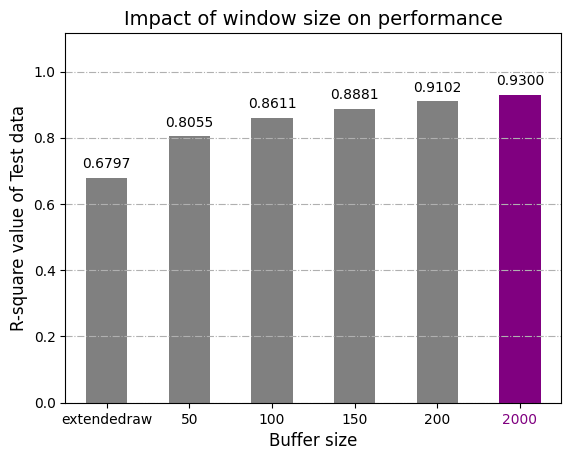

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Define bar colors: all 'skyblue' except the last one 'purple'

colors = ["grey"] * (len(df) - 1) + ["purple"]

# Plot the bar graph
ax = df.plot(x="window size", y="test_r2", kind="bar", legend=False, color=colors)

# Customize labels and title
plt.xlabel("Buffer size", fontsize=12)
plt.ylabel("R-square value of Test data", fontsize=12)
plt.title("Impact of window size on performance", fontsize=14)

# Grid with '-.' style
plt.grid(axis='y', linestyle='-.')

# Rotate x-axis labels **horizontally** for better readability
plt.xticks(rotation=0)

# Increase y-axis limit to add more space above bars
y_max = df["test_r2"].max() * 1.2  # Increase max value by 20%
plt.ylim(0, y_max)

# Add value labels on top of each bar, making the last one purple
for i, container in enumerate(ax.containers[0]):
    label_color = "purple" if df.iloc[i, df.columns.get_loc("window size")] == 2000 else "black"  
    # label_color = "purple" if i == len(df) - 1 else "black"  # Last label purple, others black
    ax.text(container.get_x() + container.get_width() / 2, 
            container.get_height() + 0.02, 
            f"{container.get_height():.4f}", 
            ha="center", va="bottom", fontsize=10, color=label_color)

# Change last xtick color to purple
xtick_labels = ax.get_xticklabels()
xtick_labels[-1].set_color("purple")

# Show the graph
plt.show()


In [80]:
df.loc[5, "test_r2"] = 0.93
df

,window size,train_mse,test_mse,train_r2,test_r2
4,Non-filtered data,0.000000e+00,0.000000,0.999000,0.425700
3,50,3.280628e-07,0.000145,0.998888,0.513635
2,100,3.322190e-07,0.000109,0.998871,0.637790
1,150,3.376114e-07,0.000086,0.998853,0.712234
0,200,3.435311e-07,0.000069,0.998833,0.770025
5,2000,0.000000e+00,0.000000,0.999000,0.930000


In [ ]:
# from itertools import product 
# from tqdm import tqdm 

# wds = 2000


# uhi_data = pd.read_csv(f'uhi_data_{wds[wd]}.csv')
# # X = uhi_data.drop(columns=['Unnamed: 0','Longitude','Latitude','UHI Index']).values
# X = uhi_data
# y = uhi_data['UHI Index'].values

# print(uhi_data.drop(columns=['Unnamed: 0','Longitude','Latitude','UHI Index']).columns)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # from sklearn.preprocessing import StandardScaler
# # scaler = StandardScaler()
# # X_train = scaler.fit_transform(X_train)
# # X_test = scaler.transform(X_test)

# learning_rates = [0.05, 0.02, 0.01, 0.005]
# max_depths = [3, 6, 10, 15, 20, 30, 40, 50]
# param_combinations = list(product(learning_rates, max_depths))

# results = []


# xgb_model = xgb.XGBRegressor(
#     # tree_method="hist",  # Mac에서 최적화된 알고리즘
#     # objective="reg:squarederror",
#     n_estimators=1000,
#     learning_rate=0.005,
#     max_depth=20,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     reg_lambda=0.001,
#     random_state=42
# )

# xgb_model.fit(
#     X_train, y_train,
#     eval_set=[(X_test, y_test)],
#     verbose=False
# )

# y_train_pred = xgb_model.predict(X_train)
# y_test_pred = xgb_model.predict(X_test)

# train_mse = mean_squared_error(y_train, y_train_pred)
# test_mse = mean_squared_error(y_test, y_test_pred)
# train_r2 = r2_score(y_train, y_train_pred)
# test_r2 = r2_score(y_test, y_test_pred)

# print(f"Train MSE: {train_mse:.4f}, Train R²: {train_r2:.4f}")
# print(f"Test  MSE: {test_mse:.4f}, Test  R²: {test_r2:.4f}")
# print("-" * 50)

# results.append({
#     "learning_rate": learning_rate,
#     "max_depth": max_depth,
#     "train_mse": train_mse,
#     "test_mse": test_mse,
#     "train_r2": train_r2,
#     "test_r2": test_r2
# })

# results_df = pd.DataFrame(results)
# results_df.to_csv(f"xgb_tuning_results_{wds[wd]}.csv", index=False)
# print(f"Complete all tuning on XGboostresgressor, making 'xgb_tuning_results_{wds[wd]}.csv' file.")

# Submission

Once you are satisfied with your model, you can proceed to make a submission. To do this, you will need to use your model to predict the Urban Heat Island (UHI) index for a set of test coordinates provided in the <b>"Submission_template.csv"</b> file and upload the results to the challenge platform.

In [38]:
#Reading the coordinates for the submission
test_file = pd.read_csv('Submission_Template_IC25.csv')
test_file.head()

,Longitude,Latitude,UHI Index
0,-77.301697,39.109247,NaN
1,-77.300382,39.113362,NaN
2,-77.300285,39.108433,NaN
3,-77.299315,39.107880,NaN
4,-77.299300,39.115225,NaN


In [40]:
import pandas as pd
import rioxarray as rxr
import rasterio
from rasterio.mask import mask
from pyproj import Transformer, CRS
from shapely.geometry import Point, mapping
import numpy as np
import torch
from tqdm import tqdm

def extract_buffered_satellite_data(tiff_path, csv_path, buffer_distance=200, use_gpu=True):
    device = torch.device("cuda" if torch.cuda.is_available() and use_gpu else "cpu")
    print(f"Using device: {device}")

    dataset = rxr.open_rasterio(tiff_path)
    tiff_crs = dataset.rio.crs
    print(f"Original TIFF CRS: {tiff_crs}")
    
    # Ensure the TIFF is in a projected coordinate system (not EPSG:4326)
    if not tiff_crs.is_projected:
        print("Reprojecting TIFF to UTM for correct buffering...")
        reprojected_tiff_path = "reprojected.tif"
        dataset = dataset.rio.reproject(dst_crs=CRS.from_epsg(32618))  # Example UTM Zone 18N
        dataset.rio.to_raster(reprojected_tiff_path)
        tiff_path = reprojected_tiff_path  # Use the reprojected file
        tiff_crs = dataset.rio.crs
        print(f"New TIFF CRS after reprojection: {tiff_crs}")
    
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    transformer = Transformer.from_crs("EPSG:4326", tiff_crs, always_xy=True)
    
    # Convert lat/lon to projected coordinates (meters)
    transformed_coords = np.array(transformer.transform(longitudes, latitudes))
    print("First 5 transformed coordinates (meters):")
    print(transformed_coords[:, :5])

    num_bands = dataset.shape[0]
    band_values = {f'B{band+1:02d}': np.full(len(df), np.nan, dtype=np.float32) for band in range(num_bands)}

    # Check raster bounds
    with rasterio.open(tiff_path) as src:
        raster_bounds = src.bounds
        print(f"Raster bounds: {raster_bounds}")
        
        for idx, (x, y) in tqdm(enumerate(zip(transformed_coords[0], transformed_coords[1])),
                                 total=len(latitudes), desc="Extracting values"):
            if not (raster_bounds.left <= x <= raster_bounds.right and raster_bounds.bottom <= y <= raster_bounds.top):
                print(f"Skipping point {idx} ({x:.2f}, {y:.2f}) - Outside raster bounds")
                continue
            
            point = Point(x, y).buffer(buffer_distance)
            geojson_geom = [mapping(point)]
            
            if idx < 5:  # Print debug info for the first few points
                print(f"Point {idx}: ({x:.2f}, {y:.2f}) -> Buffered Geometry: {geojson_geom}")
            
            try:
                out_image, _ = mask(src, geojson_geom, crop=True)
                
                # Compute the mean for each band
                for band in range(out_image.shape[0]):
                    band_values[f'B{band+1:02d}'][idx] = np.nanmean(out_image[band])
                
                if idx < 5:  # Debug output for the first few iterations
                    print(f"Extracted mean band values for point {idx}:", 
                          [np.nanmean(out_image[band]) for band in range(out_image.shape[0])])
            except Exception as e:
                print(f"Skipping point {idx} ({y:.2f}, {x:.2f}) due to error: {e}")

    band_df = pd.DataFrame(band_values)
    return band_df

# Example usage:
val_data = extract_buffered_satellite_data('/Users/ibolam/Projects/Abroad/01. UMD/25SPRING_DATA605/InfoChallege/Info-challenge-group-48/Satellite Data/S2_output_IC25(complete).tiff', 'Submission_Template_IC25.csv')

Using device: cpu
Original TIFF CRS: EPSG:4326
Reprojecting TIFF to UTM for correct buffering...
New TIFF CRS after reprojection: EPSG:32618
First 5 transformed coordinates (meters):
[[ 300987.85325361  301113.13903164  301107.63692562  301189.96102345
   301211.90737139]
 [4331422.220179   4331876.06852861 4331328.85217935 4331265.31228501
  4332080.51296547]]
Raster bounds: BoundingBox(left=297192.3140653926, bottom=4311830.711916517, right=336053.61640117853, top=4347129.585479343)


Extracting values:   1%|          | 22/3834 [00:00<00:17, 215.91it/s]

Point 0: (300987.85, 4331422.22) -> Buffered Geometry: [{'type': 'Polygon', 'coordinates': (((301187.8532536066, 4331422.220179), (301186.89019894105, 4331402.616750934), (301184.01030968723, 4331383.202114597), (301179.241320753, 4331364.163243549), (301172.62916010886, 4331345.683492527), (301164.2375064763, 4331327.940831635), (301154.1471760671, 4331311.106132396), (301142.4553442791, 4331295.341522167), (301129.2746098439, 4331280.798822762), (301114.7319104393, 4331267.618088327), (301098.9673002105, 4331255.926256539), (301082.1326009718, 4331245.83592613), (301064.3899400796, 4331237.444272498), (301045.91018905747, 4331230.832111853), (301026.8713180098, 4331226.063122919), (301007.4566816725, 4331223.183233665), (300987.8532536066, 4331222.220179), (300968.2498255407, 4331223.183233665), (300948.8351892034, 4331226.063122919), (300929.7963181557, 4331230.832111853), (300911.3165671336, 4331237.444272498), (300893.5739062414, 4331245.83592613), (300876.7392070027, 4331255.9262

Extracting values: 100%|██████████| 3834/3834 [00:03<00:00, 1045.81it/s]


In [41]:
val_data.columns =  ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']
val_data.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12
0,1284.382812,1378.309814,1618.873169,1418.439453,1944.595581,3805.305176,4554.675781,4841.813965,4835.159668,3006.789551,2008.827026
1,1263.930908,1340.740601,1548.504150,1369.369995,1892.540405,3633.719482,4293.600098,4582.199219,4601.299805,3009.570312,2030.270508
2,1264.074341,1364.810181,1617.090820,1417.643188,1921.036865,3893.004150,4773.740723,5044.018555,5026.451172,2998.084961,1973.348022
3,1268.519287,1373.620483,1642.506470,1427.627441,1961.080688,3936.139160,4813.220703,5081.797852,5055.254883,3073.187256,2016.955566
4,1310.990112,1414.388428,1630.254028,1501.089355,2004.989502,3555.252441,4162.174805,4456.208984,4458.742188,3159.524414,2194.732422


In [42]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
val_data['NDVI'] = (val_data['B08'] - val_data['B04']) / (val_data['B08'] + val_data['B04'])
val_data['NDVI'] = val_data['NDVI'].replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN

val_data['NDBI'] = (val_data['B11'] - val_data['B08']) / (val_data['B11'] + val_data['B08'])
val_data['NDBI'] = val_data['NDBI'].replace([np.inf, -np.inf], np.nan) 

val_data['NDWI'] = (val_data['B03'] - val_data['B08']) / (val_data['B03'] + val_data['B08'])
val_data['NDWI'] = val_data['NDWI'].replace([np.inf, -np.inf], np.nan)

val_data["B11/B12"] = val_data["B11"] / val_data["B12"] 
val_data["VWI"] = val_data["B08"] / val_data["B11"]  
val_data["Building_Index"] = val_data["B11"] / val_data["B12"] 
val_data["Soil_Ratio"] = val_data["B06"] / val_data["B07"] 
val_data["Vegetation_Health"] = val_data["B08"] / val_data["B02"]
val_data["NDVI_NDBI"] = val_data["NDVI"] * val_data["NDBI"]
val_data["NDVI_NDWI"] = val_data["NDVI"] * val_data["NDWI"]
val_data["NDBI_NDWI"] = val_data["NDBI"] * val_data["NDWI"]
val_data["B08_NDVI"] = val_data["B08"] * val_data["NDVI"]

In [ ]:
val_data.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,...,NDWI,B11/B12,VWI,Building_Index,Soil_Ratio,Vegetation_Health,NDVI_NDBI,NDVI_NDWI,NDBI_NDWI,B08_NDVI
0,1284.382812,1378.309814,1618.873169,1418.439453,1944.595581,3805.305176,4554.675781,4841.813965,4835.159668,3006.789551,...,-0.498854,1.496789,1.610294,1.496789,0.835472,3.512863,-0.127853,-0.272795,0.116633,2647.711182
1,1263.930908,1340.740601,1548.504150,1369.369995,1892.540405,3633.719482,4293.600098,4582.199219,4601.299805,3009.570312,...,-0.494836,1.482349,1.522543,1.482349,0.846311,3.417663,-0.111825,-0.267127,0.102505,2473.603516
2,1264.074341,1364.810181,1617.090820,1417.643188,1921.036865,3893.004150,4773.740723,5044.018555,5026.451172,2998.084961,...,-0.514468,1.519289,1.682413,1.519289,0.815504,3.695766,-0.142774,-0.288727,0.130882,2830.774170
3,1268.519287,1373.620483,1642.506470,1427.627441,1961.080688,3936.139160,4813.220703,5081.797852,5055.254883,3073.187256,...,-0.511472,1.523676,1.653592,1.523676,0.817777,3.699565,-0.138267,-0.287123,0.125978,2852.749023
4,1310.990112,1414.388428,1630.254028,1501.089355,2004.989502,3555.252441,4162.174805,4456.208984,4458.742188,3159.524414,...,-0.464302,1.439594,1.410405,1.439594,0.854181,3.150626,-0.084459,-0.230317,0.079054,2210.503906


In [ ]:
# Extracting specific columns (B02, B03, and NDVI) from the validation dataset
submission_val_data=val_data.loc[:,['B01', 'B02', 'B05', 'B06', 'B08', 'B8A', 'B11', 'B12', 'NDVI', 'NDBI', 'Building_Index', 'Soil_Ratio', 'Vegetation_Health']]
submission_val_data.head()

In [ ]:
# Feature Scaling 
submission_val_data = submission_val_data.values
transformed_submission_data = sc.transform(submission_val_data)

In [ ]:
#Making predictions
final_predictions = xgb_model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [ ]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [ ]:
#Displaying the sample submission dataframe
submission_df.head()

In [ ]:
#Dumping the predictions into a csv file.
submission_df.to_csv("Predicted_Data_IC25.csv",index = False)